# MNIST Handwritten digits classification

![l](./pics/mnist.png)

In [1]:
# to disable some warnings such as Implicit dimension choice for softmax, renamed variable etc
import warnings
warnings.filterwarnings("ignore")

#-------- For obtaining the plots in the notebook -----#
from matplotlib import pyplot as plt
%matplotlib inline

# torch module spefic to com puter vision
from torchvision import datasets,transforms

In [2]:
#---------- Basic setup ------- #
DATASET_DIRECTORY = './mnist/'
SAVE_DIRECTORY    = './models/'


# Data

In [3]:
#------- Download training data, and set transformations to be applied -----#
mnist_train = datasets.MNIST(DATASET_DIRECTORY,
                             train=True,
                             transform=transforms.ToTensor(),
                             target_transform=None,
                             download=True)

mnist_test  = datasets.MNIST(DATASET_DIRECTORY,
                             train=False,
                             transform=transforms.ToTensor(),
                             target_transform = None,
                             download = True)

In [4]:
# ---- Dimensions of dataset ---- # 
# ---- Training dataset ---- #
print("Training dataset dimensions")
print(mnist_train.train_data.size())

# ---- Test dataset ---- #
print("Test dataset dimensions")
print(mnist_test.test_data.size())

Training dataset dimensions
torch.Size([60000, 28, 28])
Test dataset dimensions
torch.Size([10000, 28, 28])


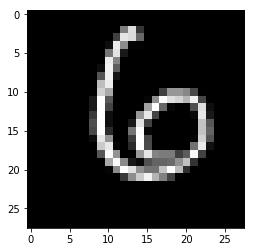

In [5]:
# --- Dislay some random image --- #
imgindex = 100
plt.imshow(mnist_test.test_data[imgindex].numpy(),cmap='gray')

# Simple network

![mnistnet](./pics/MNIST_CNN.png)

In [6]:
# ---- Build the architecture --- #
USE_CUDA = False

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F


class Model(nn.Module):
    
    def __init__(self):
        
        super(Model,self).__init__()
        
        #--- The blocks are defined here ---#
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=0)
        self.mp1   = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.mp2   = nn.MaxPool2d(kernel_size=2,stride=2)

        self.fc1   = nn.Linear(in_features=256,out_features=120)
        self.fc2   = nn.Linear(in_features=120,out_features=84)
        self.fc3  = nn.Linear(in_features=84,out_features=10)
  
        
    #--- Forward propagation ---#
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.mp1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.mp2(x)
        x = F.relu(x)
        
        x = x.view(-1,256)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)

        return x
    
model = Model()

if USE_CUDA:
    model = model.cuda()

print(model)

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### Forward Pass

In [7]:
input = torch.randn(1, 1, 28, 28)
out = model(input)
print(out)

tensor([[ 0.0205,  0.0151,  0.0707,  0.0547, -0.0489,  0.0072,  0.0950, -0.0137,
          0.0694, -0.0398]], grad_fn=<AddmmBackward>)


#### Backward Pass

In [8]:
model.zero_grad()
out.backward(torch.randn(1, 10))

# Loss Function
In this example, we will use Classification Cross-Entropy loss and SGD with momentum.<br>
Cross Entropy loss is given as:- $L=-\sum_i y_i \log(p_i)$ and $p_i=\frac{\exp^{x_i}}{\sum_k \exp^{x_k}}$

There are many other loss functions such as MSELoss, L1Loss etc. Visit [here](http://pytorch.org/docs/master/nn.html#loss-functions) for other loss functions.

#### Stochastic Gradient Descent (SGD)
$$w_{n+1} = w_{n} - \eta \triangle$$
$$\triangle = 0.9\triangle + \frac{\partial L}{\partial w}$$

Although SGD is the most popular and basic optimizer that one should first try. There are many adaptive optimizers like Adagrad,Adadelta RMSProp and many more. Visit [here](http://pytorch.org/docs/master/optim.html) for other examples.

In [9]:
# ---- Settings for training ---- #
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Mini Batch training

In [10]:
# ----- Dataloades getting datasets ready for the network ---- #
BATCH_SIZE    = 128
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=BATCH_SIZE,shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=mnist_test,batch_size=BATCH_SIZE,shuffle=True)

# ---- Knowing about how data is stored in the loader ---- #
no_of_batches_train = len(train_loader)
no_of_batches_test  = len(test_loader)
print("Train data : ", no_of_batches_train, " batches of 128 samples each")
print("Test data : ",no_of_batches_test, " batches of 128 samples each")

Train data :  469  batches of 128 samples each
Test data :  79  batches of 128 samples each


In [11]:
# --- Training procedure ---- #

from tqdm import tqdm
EPOCH = 5
running_loss = 0

# --- Iterate over epoch ---- #
for epoch in range(EPOCH):
    
    running_loss = 0
    
    # ---- Iterate over each batch --- # 
    for iter_, data in enumerate(tqdm(train_loader)):
        inputs,labels = data
        
        # --- If CUDA is available move the tensor to GPU --- #
        if USE_CUDA:
            inputs,labels = inputs.cuda(),labels.cuda()            
        
        # --- To perform back propagation the tensors should be placed in Variable --- #
        inputs,labels = Variable(inputs),Variable(labels)
        
        # --- Setting the obtained gradients to zero --- #
        optimizer.zero_grad()
        
        # --- Forward propagation --- #
        outputs = model(inputs)
        
        # --- Backward propagation and optimization --- #
        # --- Finding the error --- # 
        loss = criterion(outputs,labels)
        running_loss += loss.item()
        
        #--- Backward propogate ---#
        loss.backward()
        optimizer.step()
        
        if(iter_ % 200 == 1):
            print('average loss (epoch {}: {}/{}) : {}'.format(epoch, iter_+1, len(train_loader), running_loss / (iter_+1)))
    
    print('average loss (epoch {}) : '.format(running_loss / len(train_loader)))
    

  0%|▎                                                                                                                                                                  | 1/469 [00:00<01:03,  7.38it/s]

average loss (epoch 0: 2/469) : 2.3028913736343384


 43%|█████████████████████████████████████████████████████████████████████                                                                                            | 201/469 [00:28<00:39,  6.84it/s]

average loss (epoch 0: 202/469) : 1.3992910649221721


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 401/469 [00:56<00:09,  7.14it/s]

average loss (epoch 0: 402/469) : 0.8299770752774246


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:06<00:00,  7.04it/s]


average loss (epoch 0.7367757746914049) : 


  0%|▎                                                                                                                                                                  | 1/469 [00:00<01:00,  7.79it/s]

average loss (epoch 1: 2/469) : 0.1465969681739807


 43%|█████████████████████████████████████████████████████████████████████                                                                                            | 201/469 [00:28<00:39,  6.71it/s]

average loss (epoch 1: 202/469) : 0.14152476091933722


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 401/469 [00:57<00:10,  6.75it/s]

average loss (epoch 1: 402/469) : 0.12881082951540673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:07<00:00,  7.23it/s]


average loss (epoch 0.12584423288099292) : 


  0%|▎                                                                                                                                                                  | 1/469 [00:00<01:03,  7.37it/s]

average loss (epoch 2: 2/469) : 0.057955287396907806


 43%|█████████████████████████████████████████████████████████████████████                                                                                            | 201/469 [00:29<00:38,  6.93it/s]

average loss (epoch 2: 202/469) : 0.08927565287466686


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 401/469 [00:57<00:09,  6.93it/s]

average loss (epoch 2: 402/469) : 0.08566860302782325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:07<00:00,  7.25it/s]


average loss (epoch 0.08394618515473312) : 


  0%|▎                                                                                                                                                                  | 1/469 [00:00<00:58,  7.99it/s]

average loss (epoch 3: 2/469) : 0.07808117941021919


 43%|█████████████████████████████████████████████████████████████████████                                                                                            | 201/469 [00:29<00:40,  6.70it/s]

average loss (epoch 3: 202/469) : 0.0655300967063349


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 401/469 [00:57<00:09,  6.87it/s]

average loss (epoch 3: 402/469) : 0.06442345144106677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:07<00:00,  6.76it/s]


average loss (epoch 0.06418400251868564) : 


  0%|▎                                                                                                                                                                  | 1/469 [00:00<01:01,  7.56it/s]

average loss (epoch 4: 2/469) : 0.036359163001179695


 43%|█████████████████████████████████████████████████████████████████████                                                                                            | 201/469 [00:29<00:38,  6.93it/s]

average loss (epoch 4: 202/469) : 0.05438606074946647


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 401/469 [00:57<00:09,  7.25it/s]

average loss (epoch 4: 402/469) : 0.05436334602386501


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:07<00:00,  7.36it/s]


average loss (epoch 0.053985994710310944) : 


In [12]:
#--- Parameter dimensions ---#
#--- This includes bias and weights ---#

params = list(model.parameters())

print("FC1 ---> Weights : ",params[0].size())
print("FC1 ---> Bias    : ",params[1].size())

print("FC2 ---> Weights : ",params[2].size())
print("FC2 ---> Bias    : ",params[3].size())

print("FC3 ---> Weights : ",params[4].size())
print("FC3 ---> Bias    : ",params[5].size())


FC1 ---> Weights :  torch.Size([6, 1, 5, 5])
FC1 ---> Bias    :  torch.Size([6])
FC2 ---> Weights :  torch.Size([16, 6, 5, 5])
FC2 ---> Bias    :  torch.Size([16])
FC3 ---> Weights :  torch.Size([120, 256])
FC3 ---> Bias    :  torch.Size([120])


In [13]:
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    labels = labels
    correct += (predicted == labels).sum()
    
print(total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

10000
Accuracy of the network on the 10000 test images: 98 %
